<img src='https://www.reliance-project.eu/wp-content/uploads/2021/03/Asset-8mdpi.svg' alt='Layout' align='left' width='40%'></img> 
<img src='https://w3id.org/ro-id/bf3d5a76-1be0-4221-8ee0-b3cb40faf6f7/resources/f471f387-b3c7-4b75-91fb-cd2a38d4611a' width='350' align='right'></img>

# Copernicus data analysis and modelling of the volcanic activity at Santorini (Greece) using the RELIANCE Services

This notebook contains results based on the Copernicus ENVISAT data and GNSS data of the unrest phase at Santorini (Greece) during March 2011 - March 2012.
It contains details on geodetic data modelling of the volcanic source using the VSM tool.
The ENVISAT data are provided in the descending orbit. Cumulative uplift on Nea Kameni reached almost 9 cm Line of Sight at the end of the observation period, while the maximum deformation of 14 cm Line of Sight was observed at Cape Skaros NNW of Fira.

This notebook demonstrates the use of **EGI Notebook** and the **ROHub APIs** to document a complete scientific process (from input data to results) with the creation of a **Research Object**.

---
**VSM - Volcanic and Seismic source Modelling** is a Python code to perform inversions of geodetic data. \
**Code** https://github.com/EliTras/VSM \
**License** E. Trasatti - INGV (elisa.trasatti@ingv.it), covered by GNU-GPL License https://github.com/EliTras/VSM/blob/main/license.lic

**References** \
Monitoring Santorini volcano (Greece) breathing from space, by M. Foumelis,  E. Trasatti, E. Papageorgiou, S. Stramondo, I. Parcharidis \
Geophys. J. Int., 2013. https://doi.org/10.1093/gji/ggs135 . Full text https://academic.oup.com/gji/article/193/1/161/747252

## Install libraries

In [4]:
import sys
!{sys.executable} -m pip install -r /home/jovyan/datahub/Reliance/Environments/ingv_reqs.txt

In [5]:
import sys
import os
import pathlib
import pandas as pd
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ['HOME'], "datahub/Reliance/Geohazard/VSM"))
import VSM

### Define the local folder & folder with data

In [6]:
# personal area working folder
folder_work_local = './'
# input file to be written
filename_in = 'VSM_input.txt'
VSM_FILE = os.path.join(folder_work_local, filename_in)

# data folder from personal area
folder_data = os.path.join(os.environ['HOME'], "datahub/Reliance/Geohazard_Santorini/input/")

### Input InSAR & GNSS data


<img src="./santorini_data.gif" width="550" align="center">

In [8]:
#Add the input files. By default all file names are 'None'. Set to 'None those unused'

# SAR filename(s)
sar_file = os.path.join(folder_data,'obs_sar.txt')
#GNSS filename
gps_file = os.path.join(folder_data, 'obs_gps.txt')
# levelling filename
lev_file = 'None'
# EDM filename
edm_file = 'None'
#tilt filename
tlt_file = 'None'
# strain filename
srn_file = 'None'

### Weights

In [9]:
# SAR weight
sar_weight = 1.
# GNSS weight
gps_weight = 1.
# levelling weight
lev_weight = 0.
# EDM weight
edm_weight = 0.
# tilt weight
tlt_weight = 0.
# strain weight
srn_weight = 0.

In [10]:
f = open(VSM_FILE, "w")
f.write(folder_work_local+'\n')
f.write(sar_file+'\n'+gps_file+'\n'+lev_file+'\n'+edm_file+'\n'+tlt_file+'\n'+srn_file+'\n')
f.write(str(sar_weight)+'\n'+str(gps_weight)+'\n'+str(lev_weight)+'\n'+str(edm_weight)+'\n'+str(tlt_weight)+'\n'+str(srn_weight)+'\n');

### Forward model

In [11]:
# shear modulus (Pa)
mu = 5e9
# Poisson ratio
ni = 0.25

# number of sources
num_sources = 1

# write this part in the input file
f.write(str(mu)+'\n')
f.write(str(ni)+'\n')
f.write(str(num_sources)+'\n');

### Definition of forward model

#### Isotropic Point Source
**Model 0** The Mogi (1958) point source model represents an isotropic point source. Parameters:
- East coordinate of the source center
- North coordinate of the source center
- Depth of the source source center
- Volume variation

#### Isotropic Finite Volume
**Model 1** The McTigue (1987) finite volume model is an evolution of the Mogi model and represents a spherical source with finite volume. Parameters:
- East coordinate of the source center
- North coordinate of the source center
- Depth of the source center
- Radius of the sphere
- $\Delta P/ \mu$ (Overpressure vs shear modulus ratio)

#### Penny-shaped crack
**Model 2** The penny shaped crack (Fialko et al., 2001) is a disk with a radius and no vertical extension. Parameters:
- East coordinate of the disk center
- North coordinate of the disk center
- Depth of the disk center
- Radius of the disk
- $\Delta P/ \mu$ (Overpressure vs shear modulus ratio)

#### Spheroid
**Model 3** The spheroid (Yang et al., 1988) is a finite-volume cavity with a constant overpressure on the boundary. It can be arbitrarily oriented in space Parameters:
- East coordinate of the source center
- North coordinate of the source center
- Depth of the source center
- Semi-major axis
- Ratio of semi-minor vs semi-major axes
- $\Delta P/ \mu$ (Overpressure vs shear modulus ratio)
- Strike angle
- Dip angle

#### Moment tensor
**Model 4** The moment tensor (Davis, 1986) is a point source defined by its equivalent combination of dipoles and double forces. The P$_{ij}$ matrix must be defined, whose diagonal elements are the dipoles, while the off-diagonal are the double-forces according to catersian coordinates. The results must be interpreted following Davis (1986) tables to find the shape of the ellipsoid and its orientation. Parameters:
- East coordinate of the source center
- North coordinate of the source center
- Depth of the source center
- P$_{xx}$
- P$_{yy}$
- P$_{zz}$
- P$_{xy}$
- P$_{yz}$
- P$_{zx}$

#### Rectangular dislocation
**Model 5** The rectangular dislocation model (Okada, 1985) is a rectangular plane undergoing shear slip and/or tensile opening/closing. Two configurations are available. The first uses strike-slip and dip-slip on the fault, while the other uses the total slip and the rake angle. Parameters:
- East coordinate of the top left corner
- North coordinate of the top left corner
- Depth of the top
- Length
- Width
- Strike angle
- Dip angle
- Strike-slip, or, conversely, total slip
- Dip-slip, or, conversely, rake angle
- Tensile movement

In [12]:
# define the source identifier of the forward model
# 0=Mogi 1=McTigue 2=Sill 3=Spheroid 4=Ellipsoid 5=Fault/Dike
# comment or uncomment the lines needed, based on the number of sources employed

sorg_identifier = 3 
#parameters minimum and maximum (minimum <= maximum)
param1 = (353500.,   357500.)  # east
param2 = (4030000.,  4034000.)  # north
param3 = (1000.,  5000.) # depth
param4 = (1600, 1600)    # semi major axis
param5 = (0.333, 0.333)  # ratio between minimum and maximum axes
param6 = (1.e-4, 1.e-2)  # intensity DP/mu
param7 = (0.,  359.) # strike
param8 = (0., 89.9)   # dip

bounds = [param1,param2,param3,param4,param5,param6,param7,param8]

#Uncomment and define the style ('S' or 'R') in case of Okada (Fault/Dike source)
#okada_mode = 'S'

# write this part in the input file
if(sorg_identifier!= 5):
    f.write(str(sorg_identifier)+'\n')
else:
    f.write(str(sorg_identifier)+' '+okada_mode+'\n')
       
for k in range(len(bounds)):
    row = str(list(bounds[k])[0])+'\t'+str(list(bounds[k])[1])+'\n'
    f.write(row)

### Inversion algorithms

In [13]:
# inversion choice NA = 0 BI = 1
inversion_choice = 0
# accordingly define the sampling parameters
sampl1 = 1000
sampl2 = 300
sampl3 = 15
f.write(str(inversion_choice)+'\n')
if(inversion_choice == 0):
    f.write(str(sampl1)+' '+str(sampl2)+'\n')
    f.write(str(sampl3)+'\n')
else:
    f.write(str(sampl1)+'\n')
    f.write(str(sampl2)+'\n')

### Plots

In [14]:
# Number of burn-in models. Default is 2000. No plots for -1
num_skip = 2000
f.write(str(num_skip)+'\n');

In [15]:
# END of settings for the VSM input!
f.close()

## Launch VSM

In [16]:
# Read VSM input
VSM.read_VSM_settings(VSM_FILE)



*******************************************************************************

                   VSM exectution begins

Start reading settings of VSM from input file -->
./VSM_input.txt 

Data -->
InSAR data file # 1 /home/jovyan/datahub/Reliance/Geohazard_Santorini/input/obs_sar.txt
GNSS data file /home/jovyan/datahub/Reliance/Geohazard_Santorini/input/obs_gps.txt

Source 1 considered -->
 Spheroid Finite Volume (Yang et al., 1988)

There are 8 total free parameters
Parameters actually inverted -->  6
xcen (353500.0, 357500.0)
ycen (4030000.0, 4034000.0)
depth (1000.0, 5000.0)
dP_mu (0.0001, 0.01)
strike (0.0, 359.0)
dip (0.0, 89.9)

Inversion tool chosen --> NEIGHBOURHOOD ALGORITHM
N. of samples:  1000 N. of re-samples 300
N. of iterations:  15

Number of burn-in samples for the plots --> 2000 





Reading data...
Found  2409 InSAR data in dataset # 1
Found  22 GPS data

Output folder is -->
 ./

                    All input read

*******************************************************************************

NEIGHBOURHOOD ALGORITM running...
Searcher(iteration=1, samples=1000, best=6.363518e+00)
Searcher(iteration=2, samples=2000, best=6.363518e+00)
Searcher(iteration=3, samples=3000, best=6.363518e+00)
Searcher(iteration=4, samples=4000, best=5.829401e+00)
Searcher(iteration=5, samples=5000, best=4.409451e+00)
Searcher(iteration=6, samples=6000, best=4.409451e+00)
Searcher(iteration=7, samples=7000, best=4.362908e+00)
Searcher(iteration=8, samples=8000, best=4.348099e+00)
Searcher(iteration=9, samples=9000, best=4.216447e+00)
Searcher(iteration=10, samples=10000, best=4.216447e+00)
Searcher(iteration=11, samples=11000, best=4.206429e+00)
Searcher(iteration=12, samples=12000, best=4.191525e+00)
Searcher(iteration=13, samples=13000, best=4.182476e+00)
Searcher(iteration=14, sa

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.



Plotting parameters sampling 



findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F


Plotting 1D and 2D parameter marginals 



findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


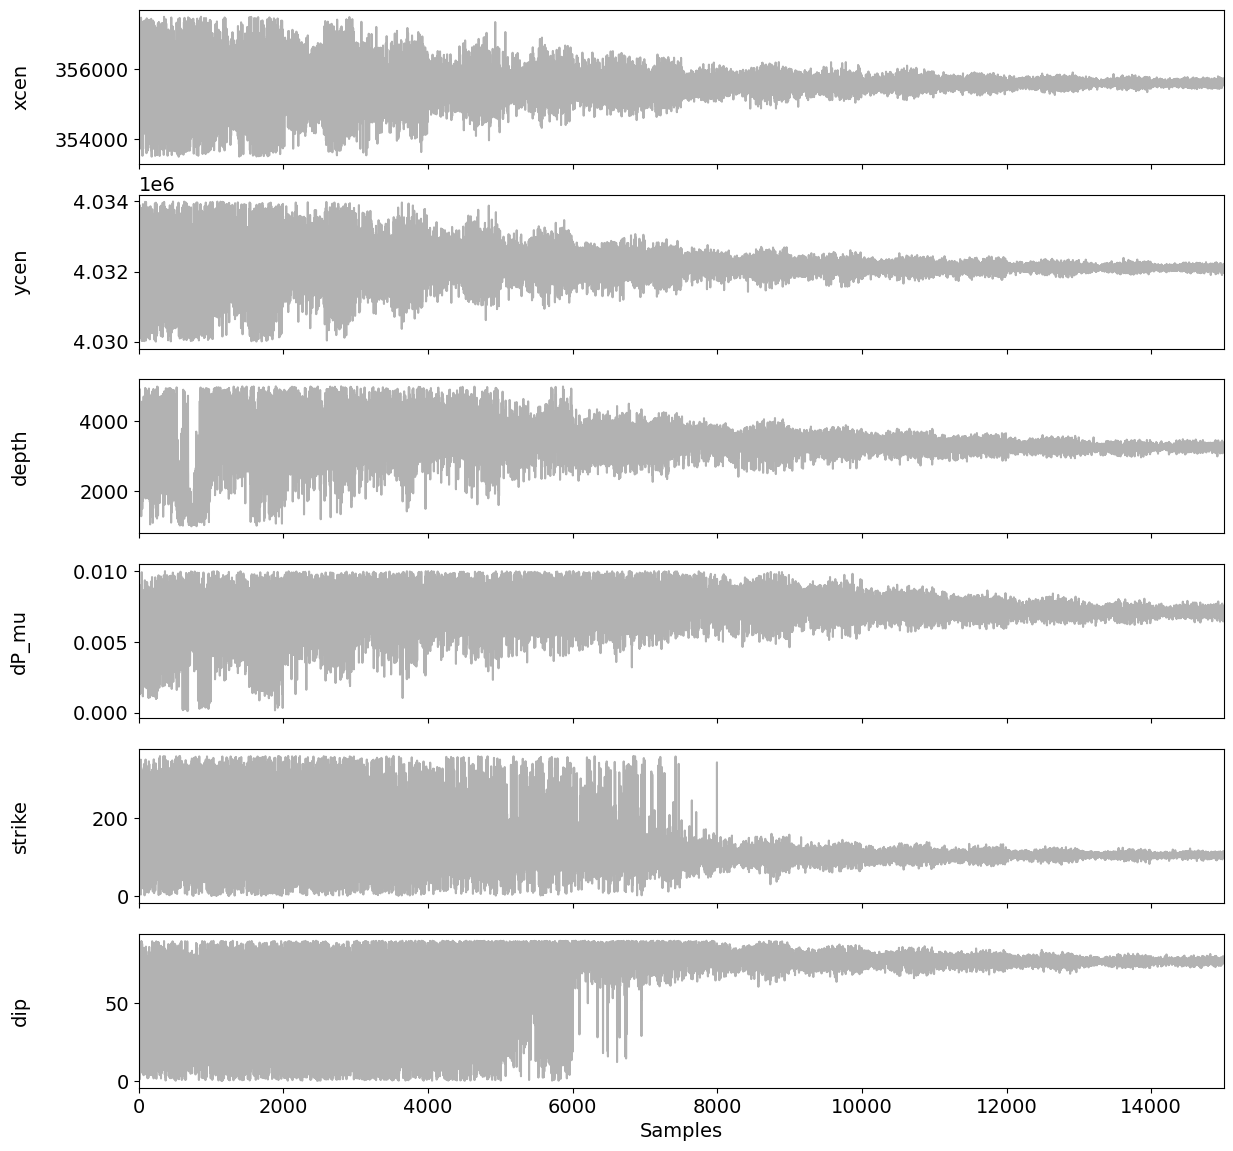

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

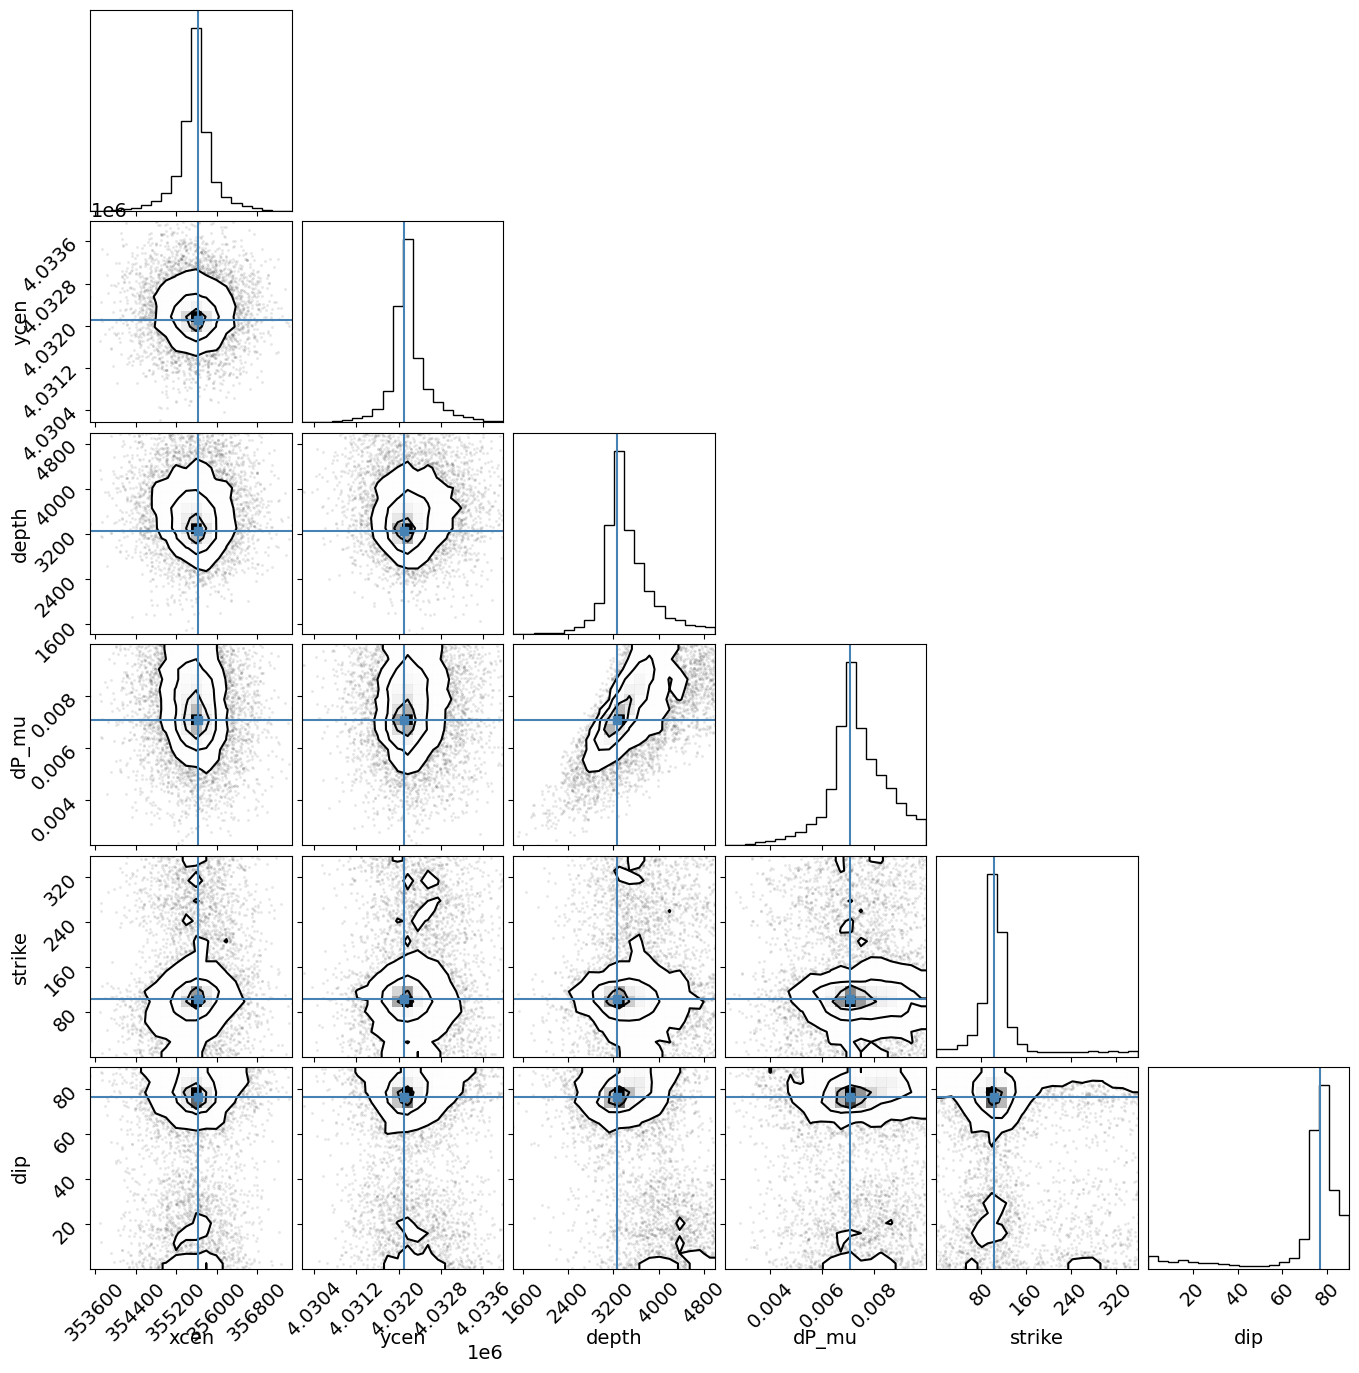

In [17]:
# Run VSM
try:
    VSM.iVSM()
except FileNotFoundError: 
    pass

--------
## Post Processing

### Plot data, model and residuals

In [7]:
synth_file = os.path.join(folder_work_local, 'VSM_synth_sar.csv')
best_file  = os.path.join(folder_work_local, 'VSM_best.csv')
out_file   = os.path.join(folder_work_local, 'VSM_res_sar.png')

# UTM zone
zone = 35
southern_hemisphere = False

AttributeError: PathCollection.set() got an unexpected keyword argument 'fontname'

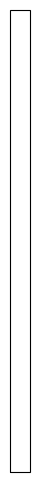

In [14]:
# My data in UTM coordinates
db_sar = pd.read_csv(synth_file)
d_sar = db_sar.values

# Split into east and north coordinates
east, north = d_sar[:,0],d_sar[:,1]
data = d_sar[:,3]
synth = d_sar[:,2]
res = data - synth

dmax = max(max(data),max(synth))
dmin = min(min(data),min(synth))
resmax = max(res)
resmin = min(res)
resext = max(resmax, -resmin)

db_best = pd.read_csv(best_file)
best = db_best.values

# Define the projection
#crs=ccrs.PlateCarree()
mycrs=ccrs.UTM(zone=zone, southern_hemisphere=southern_hemisphere)

fig=plt.figure(figsize=(15,6))

## PANEL DATA ##########
# alternative palette RdYlBu_r
ax = plt.subplot(131, projection=mycrs)
#ax.coastlines(resolution='10m')
img = ax.scatter(east, north,5, data, cmap="viridis", vmin=dmin, vmax = dmax)
#palette
cbar = plt.colorbar(img,orientation='horizontal')
cbar.set_label('LOS (m)',fontname='Sans')
# Get the extent of the axis
extent = ax.get_extent()
# Attempt to set the axis extent
ax.set_extent(extent, crs=mycrs)
plt.title('Data',fontsize = 16, pad=5,fontname='Sans')

## PANEL MODEL ##########
ax = plt.subplot(132, projection=mycrs)
ax.plot(best[:,0],best[:,1],marker='+',color='black')
#ax.coastlines(resolution='10m')
img = ax.scatter(east, north,5, synth,cmap="viridis", vmin=dmin, vmax = dmax)
#palette
cbar = plt.colorbar(img,orientation='horizontal')
cbar.set_label('LOS (m)')
# Get the extent of the axis
extent = ax.get_extent()
# Attempt to set the axis extent
ax.set_extent(extent, crs=mycrs)
plt.title('Model',fontsize = 16, pad=5)

## PANEL RESIDUALS ##########
ax = plt.subplot(133, projection=mycrs)
#ax.coastlines(resolution='10m')
img = ax.scatter(east, north,5, data - synth,cmap="bwr",vmin=resext, vmax = -resext)
#palette
cbar = plt.colorbar(img,orientation='horizontal')
cbar.set_label('LOS (m)')
# Get the extent of the axis
extent = ax.get_extent()
# Attempt to set the axis extent
ax.set_extent(extent, crs=mycrs)
# Title for plot
plt.title('Residual',fontsize = 16, pad=5)

plt.savefig(out_file)
plt.show()

### Create geospatial reference of the study area with geoJSON-LD format

In [22]:
import json
from pyproj import Transformer
from geojson import Polygon

#for geoJSON
EPSG = "EPSG:32635"

transformer = Transformer.from_crs(EPSG,"EPSG:4326")

lat, lon = transformer.transform(east, north)

# This is geoJSON-LD format
geojson_as_text_point_python = { "@context": { "geojson": "https://purl.org/geojson/vocab#" }, "type": "Feature", "geometry": { "type": "Polygon",  "coordinates": [[(lon.min(), lat.min()), (lon.max(),lat.min()), (lon.max(),lat.max()), (lon.min(), lat.max()), (lon.min(), lat.min())]] }}
with open(os.path.join(folder_work_local, 'AOI.geojson'), 'w') as f:
    json.dump(geojson_as_text_point_python,f)
f.close()

geojson_as_text_point_python


{'@context': {'geojson': 'https://purl.org/geojson/vocab#'},
 'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[(25.322162850585062, 36.33140654355215),
    (25.486383580741393, 36.33140654355215),
    (25.486383580741393, 36.48215433130998),
    (25.322162850585062, 36.48215433130998),
    (25.322162850585062, 36.33140654355215)]]}}

------------------------------------
## Copy resources to the EGI Datahub

### Create folders in the EGI datahub cloud 

In [23]:
volcano = 'Santorini_EGI'
WORKDIR_FOLDER = os.path.join(os.environ['HOME'], "datahub/Reliance/Geohazard" + '_' + volcano)
print("WORKDIR FOLDER: ", WORKDIR_FOLDER)

WORKDIR FOLDER:  /home/jovyan/datahub/Reliance/Geohazard_Santorini_EGI


In [24]:
INPUT_DATA_DIR  = os.path.join(WORKDIR_FOLDER, 'input')
OUTPUT_DATA_DIR = os.path.join(WORKDIR_FOLDER, 'output')
TOOL_DATA_DIR   = os.path.join(WORKDIR_FOLDER, 'tool')

list_folders = [INPUT_DATA_DIR, OUTPUT_DATA_DIR, TOOL_DATA_DIR]

for folder in list_folders:
    pathlib.Path(folder).mkdir(parents=True, exist_ok=True)

print(list_folders)

['/home/jovyan/datahub/Reliance/Geohazard_Santorini_EGI/input', '/home/jovyan/datahub/Reliance/Geohazard_Santorini_EGI/output', '/home/jovyan/datahub/Reliance/Geohazard_Santorini_EGI/tool']


### Copy resources from personal area to the EGI datahub

#### Input

In [25]:
# copy the VSM input
os.popen(f'cp {VSM_FILE} {INPUT_DATA_DIR}')

# copy the data
os.popen(f'cp {sar_file} {INPUT_DATA_DIR}')
os.popen(f'cp {gps_file} {INPUT_DATA_DIR}');

#### Results

In [26]:
# copy the AOI
fname = os.path.join(folder_work_local, 'AOI.geojson')
os.popen(f'cp {fname} {OUTPUT_DATA_DIR}')

# copy the statistics
fname = os.path.join(folder_work_local, 'VSM_1D.csv')
os.popen(f'cp {fname} {OUTPUT_DATA_DIR}')
fname = os.path.join(folder_work_local, 'VSM_2D.txt')
os.popen(f'cp {fname} {OUTPUT_DATA_DIR}')
fname = os.path.join(folder_work_local, 'VSM_1D2D.png')
os.popen(f'cp {fname} {OUTPUT_DATA_DIR}')
fname = os.path.join(folder_work_local, 'VSM_params.png')
os.popen(f'cp {fname} {OUTPUT_DATA_DIR}')

# copy the models
fname = os.path.join(folder_work_local, 'VSM_models.csv')
os.popen(f'cp {fname} {OUTPUT_DATA_DIR}')
fname = os.path.join(folder_work_local, 'VSM_best.csv')
os.popen(f'cp {fname} {OUTPUT_DATA_DIR}')

# copy the synth data & residuals plot
fname = os.path.join(folder_work_local, 'VSM_synth*.csv')
os.popen(f'cp {fname} {OUTPUT_DATA_DIR}')
fname = os.path.join(folder_work_local, 'VSM_res*.png')
os.popen(f'cp {fname} {OUTPUT_DATA_DIR}')

# copy the log
fname = os.path.join(folder_work_local, 'VSM.log')
os.popen(f'cp {fname} {OUTPUT_DATA_DIR}');

#### Tool

In [29]:
#copy this notebook!
fname = os.path.join(folder_work_local, 'santorini_new.ipynb')
os.popen(f'cp {fname} {TOOL_DATA_DIR}')